In [1]:
# GIS imports
import rasterio

# Data analysis imports
from sklearn.ensemble import RandomForestClassifier
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb
from tools import get_superpixel_stds_as_features, get_superpixel_means_as_features, get_array_from_features, reproject_arr_to_match_profile
from sklearn.model_selection import train_test_split
from skimage.restoration import denoise_tv_bregman

# misc imports
import pathlib
from pathlib import Path
from xml.dom import minidom
from typing import List

Validation chip classifications:

0 – not water

1—water

7—will not classify 

9—clouds  

In [2]:
planet_ids = [f.name for f in Path('../data/planet_images_cropped').iterdir() if f.is_dir() and f.name != 'planet_images_cropped']

cropped_chips = [list(Path(f'../data/planet_images_cropped/{id}').glob('cropped_*.tif'))[0] for id in planet_ids]
classification_chips = [list(Path(f'../data/planet_images_cropped/{id}').glob('classification_*.tif'))[0] for id in planet_ids]
xml_paths = [list(Path(f'../data/{id}').glob('*.xml'))[0] for id in planet_ids]
full_images = [list(Path(f'../data/{id}/').glob(f'{id}*.tif'))[0] for id in planet_ids]

print(list(map(len, [cropped_chips, classification_chips, full_images, xml_paths])))

[4, 4, 4, 4]


In [78]:
# Chips that have been downloaded
planet_ids

['20211003_161639_91_241d',
 '20211021_133031_75_245a',
 '20210906_101112_28_225a',
 '20211021_182217_09_2456']

### Helper functions

In [21]:
def return_reflectance_coeffs(xml_file:str|pathlib.PosixPath, band_idx:int|List):
    assert isinstance(band_idx, (list, int)), "band_idx must be of type int or list"
    
    if isinstance(band_idx, int):
        band_idx = [band_idx]
    
    # parse XML metadata to obtain TOA reflectance coefficients
    xmldoc = minidom.parse(str(xml_file))
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in [str(x) for x in band_idx]:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    
    return coeffs

In [22]:
def return_img_bands(img:str|pathlib.PosixPath, band_idx:int|list, denoising_weight=None)->np.ndarray:
    if isinstance(band_idx, int):
        band_idx = list(band_idx)
    
    img_stack = []
    with rasterio.open(img) as ds:
        for idx in band_idx:
            if denoising_weight is not None:
                img_stack.append(denoise_tv_bregman(ds.read(idx), denoising_weight))
            else:
                img_stack.append(ds.read(idx))
    
    return np.stack(img_stack, axis = 0)

In [55]:
green_idx, red_idx, nir_idx = 4, 6, 8 # band 6 is red, band 7 is red-edge

In [65]:
def return_trained_rf(chip:str|pathlib.PosixPath, classification:str|pathlib.PosixPath, xml_file:str|pathlib.PosixPath):

    min_value = 1e-5 # filler value for data to prevent divide by zero errors

    coeffs = return_reflectance_coeffs(xml_file, [green_idx, red_idx, nir_idx])
    
    chip_img = return_img_bands(chip, [green_idx, red_idx, nir_idx], denoising_weight=None)
    # chip_img = return_img_bands(chip, [green_idx, red_idx, nir_idx], denoising_weight=None)
    with rasterio.open(chip) as src_ds:
        ref_profile = src_ds.profile

    green = chip_img[0]*coeffs[green_idx]
    red = chip_img[1]*coeffs[red_idx]
    nir = chip_img[2]*coeffs[nir_idx]

    with rasterio.open(classification) as src_ds:
        cl = src_ds.read(1)
        cl_profile = src_ds.profile

    # some classification extents are not the same as the corresponding chip extent
    # this will be reflected in the transforms of the two rasters
    # if this is the case, reproject the classification such that it matches the chip extent
    if ref_profile['transform'] != cl_profile['transform']:
        ref_transform = ref_profile['transform']
        width = ref_profile['width']
        height = ref_profile['height']
        ref_profile = cl_profile.copy()
        ref_profile.update({'transform':ref_transform, 'width':width, 'height': height})
        cl, _ = reproject_arr_to_match_profile(cl, cl_profile, ref_profile)
        cl = np.squeeze(cl)

    # 
    ndwi_1 = (green - red)/(green + red)
    ndwi_1 = np.where(np.isnan(ndwi_1), min_value, ndwi_1)

    ndwi_2 = (green - nir)/(green + nir)
    ndwi_2 = np.where(np.isnan(ndwi_2), min_value, ndwi_2)

    img_stack = np.stack([red, ndwi_1, ndwi_2], axis=-1)
    segments = felzenszwalb(img_stack, sigma=0, min_size=3)

    std_features = get_superpixel_stds_as_features(segments, img_stack)
    mean_features = get_superpixel_means_as_features(segments, img_stack)

    X = np.concatenate([mean_features, std_features], axis = 1)
    
    # We have superpixels, we now need to map each of the segments to the associated label
    # A 0 value indicates no label for the segment
    class_features = np.zeros((mean_features.shape[0], 1))
    for class_id in [0, 1]:
        # Get all superpixel labels with particular id
        superpixel_labels_for_class = np.unique(segments[class_id == cl])
        # Label those superpixels with approrpriate class
        class_features[superpixel_labels_for_class] = class_id

    class_arr_superpixels = get_array_from_features(segments, class_features)

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, class_features, test_size=0.15, random_state=0)

    # Define an RF to be trained. setting n_jobs = -1 uses all available processors
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True, random_state=0, n_jobs=-1)

    # # train model and print performance
    rf.fit(X_train, y_train.ravel())
    print("Model OOB score: ", rf.oob_score_)
    print("Model test score: ", rf.score(X_test, y_test.ravel()))

    return rf

In [63]:
def generate_inference(rf, img:str|pathlib.PosixPath, xml_file:str|pathlib.PosixPath):

    min_value = 1e-5 # filler value for data to prevent divide by zero errors

    coeffs = return_reflectance_coeffs(xml_file, [green_idx, red_idx, nir_idx])
    
    full_img = return_img_bands(img, [green_idx, red_idx, nir_idx], denoising_weight=None)

    green = full_img[0]*coeffs[green_idx]
    red = full_img[1]*coeffs[red_idx]
    nir = full_img[2]*coeffs[nir_idx]

    ndwi_1 = (green - red)/(green + red)
    ndwi_1 = np.where(np.isnan(ndwi_1), min_value, ndwi_1)

    ndwi_2 = (green - nir)/(green + nir)
    ndwi_2 = np.where(np.isnan(ndwi_2), min_value, ndwi_2)

    img_stack = np.stack([red, ndwi_1, ndwi_2], axis=-1)
    segments = felzenszwalb(img_stack, sigma=0, min_size=3)

    std_features = get_superpixel_stds_as_features(segments, img_stack)
    mean_features = get_superpixel_means_as_features(segments, img_stack)

    X = np.concatenate([mean_features, std_features], axis = 1)

    y = rf.predict(X)

    return get_array_from_features(segments, np.expand_dims(y, axis=1))


### Example 1

In [66]:
# First, train a RF
idx = 2
img, chip, classification, xml_file = full_images[idx], cropped_chips[idx], classification_chips[idx], xml_paths[idx]
rf = return_trained_rf(chip, classification, xml_file)

/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:33: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:36: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


Model OOB score:  0.9958801352559369
Model test score:  0.9959726898027247


In [67]:
inference = generate_inference(rf, img, xml_file)

/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:13: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:16: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


In [68]:
with rasterio.open(img) as src_ds:
    profile_copy = src_ds.profile
    profile_copy.update({'count':1, 'dtype':np.uint8, 'nodata':255})
    with rasterio.open(f"{classification.parent}/full_chip_1_{classification.name}", 'w', **profile_copy) as dst_ds:
        dst_ds.write(inference.astype(np.uint8).reshape(1, *inference.shape))

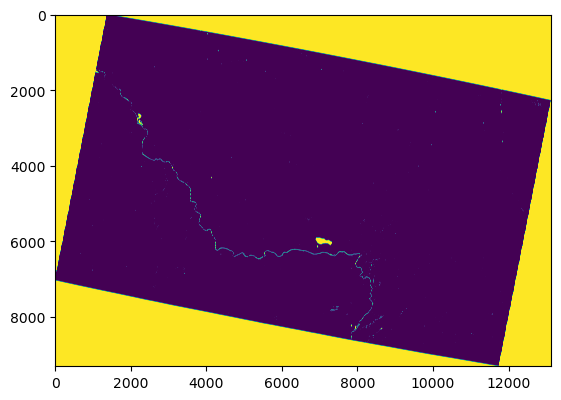

In [69]:
plt.imshow(inference)

### Example 2

In [71]:
idx = 1
img, chip, classification, xml_file = full_images[idx], cropped_chips[idx], classification_chips[idx], xml_paths[idx]
rf = return_trained_rf(chip, classification, xml_file)

inference = generate_inference(rf, img, xml_file)

with rasterio.open(img) as src_ds:
    profile_copy = src_ds.profile
    profile_copy.update({'count':1, 'dtype':np.uint8, 'nodata':255})
    with rasterio.open(f"{classification.parent}/full_chip_1_{classification.name}", 'w', **profile_copy) as dst_ds:
        dst_ds.write(inference.astype(np.uint8).reshape(1, *inference.shape))

/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:33: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:36: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


Model OOB score:  0.9956151780089995
Model test score:  0.9954770597400181


/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:13: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:16: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


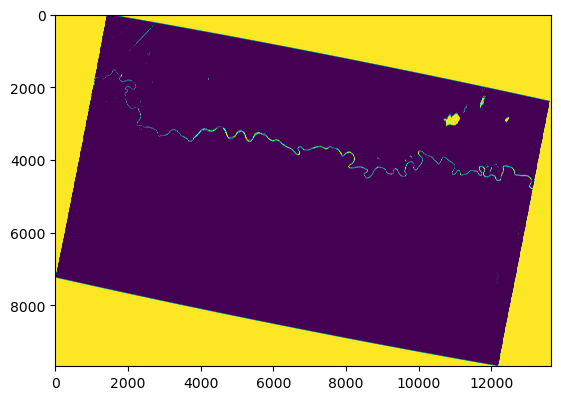

In [75]:
plt.imshow(inference)

### Example 3

In [76]:
idx = 3
img, chip, classification, xml_file = full_images[idx], cropped_chips[idx], classification_chips[idx], xml_paths[idx]
rf = return_trained_rf(chip, classification, xml_file)

inference = generate_inference(rf, img, xml_file)

with rasterio.open(img) as src_ds:
    profile_copy = src_ds.profile
    profile_copy.update({'count':1, 'dtype':np.uint8, 'nodata':255})
    with rasterio.open(f"{classification.parent}/full_chip_1_{classification.name}", 'w', **profile_copy) as dst_ds:
        dst_ds.write(inference.astype(np.uint8).reshape(1, *inference.shape))

/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:33: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:36: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


Model OOB score:  0.9984613080753247
Model test score:  0.9986422699549191


/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:13: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:16: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


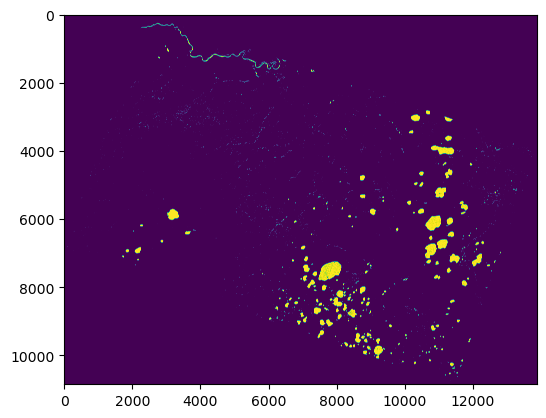

In [77]:
plt.imshow(inference)

### Example 4

/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:33: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/4151336197.py:36: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


Model OOB score:  0.99057578716828
Model test score:  0.9897920808037394


/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:13: RuntimeWarning: invalid value encountered in divide
  ndwi_1 = (green - red)/(green + red)
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_48050/340485757.py:16: RuntimeWarning: invalid value encountered in divide
  ndwi_2 = (green - nir)/(green + nir)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


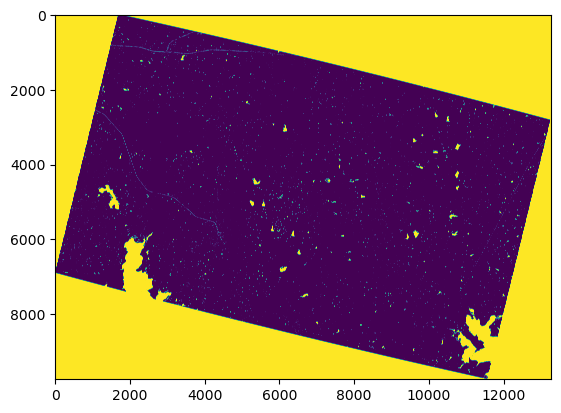

In [79]:
idx = 0
img, chip, classification, xml_file = full_images[idx], cropped_chips[idx], classification_chips[idx], xml_paths[idx]
rf = return_trained_rf(chip, classification, xml_file)

inference = generate_inference(rf, img, xml_file)

with rasterio.open(img) as src_ds:
    profile_copy = src_ds.profile
    profile_copy.update({'count':1, 'dtype':np.uint8, 'nodata':255})
    with rasterio.open(f"{classification.parent}/full_chip_1_{classification.name}", 'w', **profile_copy) as dst_ds:
        dst_ds.write(inference.astype(np.uint8).reshape(1, *inference.shape))

plt.imshow(inference)